In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
import torch

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road - Copy\Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

48

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 2 0 0 0 0 2 2 1 2 1 0 0 1 2 2 2 1 1 1 1 2 2 0 1 1 1 2 2 2]


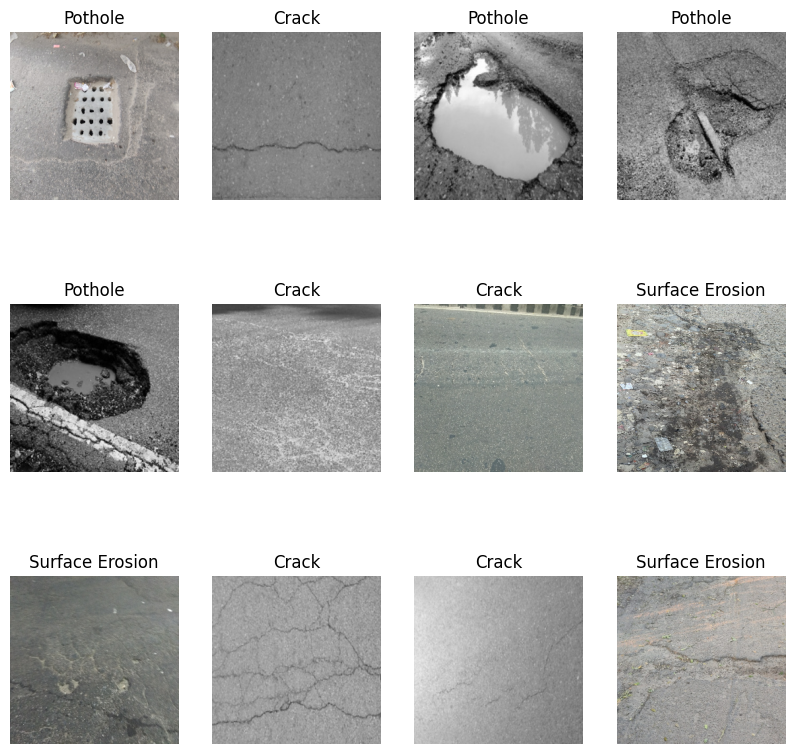

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
len(dataset)
#80% for training
#10% for validation
#10% for test

48

In [9]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [10]:
train_data = dataset.take(38)
len(train_data)

38

In [11]:
test_data = dataset.skip(38)
len(test_data)

10

In [12]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [13]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [14]:
test_data = test_data.skip(4)
len(test_data)

6

In [15]:
# Dataset split function
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [16]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [17]:
len(train_data)
len(validation_data)
len(test_data)

6

In [18]:
# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Cache, shuffle and prefetch
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [22]:
def build_resnet50_model():
    base = tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [23]:
def build_efficientnet_model():
    base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [24]:
def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [25]:
model = build_vgg19_model()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 516s 6us/step


In [26]:
# n_classes = 3
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])
# model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
# history = model.fit(
#     train_data,
#     epochs=EPOCH,
#     batch_size=BATCH_SIZE,
#     verbose = 1,
#     validation_data=validation_data
# )

# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50


38/38 ━━━━━━━━━━━━━━━━━━━━ 332s 8s/step - accuracy: 0.3951 - loss: 1.0798 - val_accuracy: 0.5164 - val_loss: 0.9724
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.5723 - loss: 0.8931 - val_accuracy: 0.5574 - val_loss: 0.8966
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 280s 7s/step - accuracy: 0.5366 - loss: 0.8734 - val_accuracy: 0.6475 - val_loss: 0.8478
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - accuracy: 0.6664 - loss: 0.7780 - val_accuracy: 0.6639 - val_loss: 0.8036
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - accuracy: 0.6641 - loss: 0.8029 - val_accuracy: 0.6393 - val_loss: 0.7827
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.6794 - loss: 0.7641 - val_accuracy: 0.7049 - val_loss: 0.7373
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - accuracy: 0.6853 - loss: 0.7404 - val_accuracy: 0.7213 - val_loss: 0.7076
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - accuracy: 0.7178 - loss: 0.7245 - val_accuracy: 0.7377 - val_loss: 0.

In [30]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.7705 - loss: 0.5765


[0.5045568943023682, 0.8125]

In [31]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
history.history['accuracy']

[0.4429751932621002,
 0.5677685737609863,
 0.5785123705863953,
 0.660330593585968,
 0.6719008088111877,
 0.6743801832199097,
 0.7033057808876038,
 0.7033057808876038,
 0.7181817889213562,
 0.7363636493682861,
 0.7446280717849731,
 0.7479338645935059,
 0.7528925538063049,
 0.7644628286361694,
 0.7619834542274475,
 0.7595041394233704,
 0.7719008326530457,
 0.7661157250404358,
 0.7710743546485901,
 0.7768595218658447,
 0.7603305578231812,
 0.7710743546485901,
 0.7702479362487793,
 0.7801653146743774,
 0.7785124182701111,
 0.784297525882721,
 0.7851239442825317,
 0.7925620079040527,
 0.773553729057312,
 0.7859504222869873,
 0.7900826334953308,
 0.7809917330741882,
 0.7851239442825317,
 0.797520637512207,
 0.7818182110786438,
 0.7925620079040527,
 0.7983471155166626,
 0.804958701133728,
 0.8008264303207397,
 0.7942149043083191,
 0.8033058047294617,
 0.78925621509552,
 0.8041322231292725,
 0.8057851195335388,
 0.7942149043083191,
 0.8099173307418823,
 0.8041322231292725,
 0.8057851195335388,

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

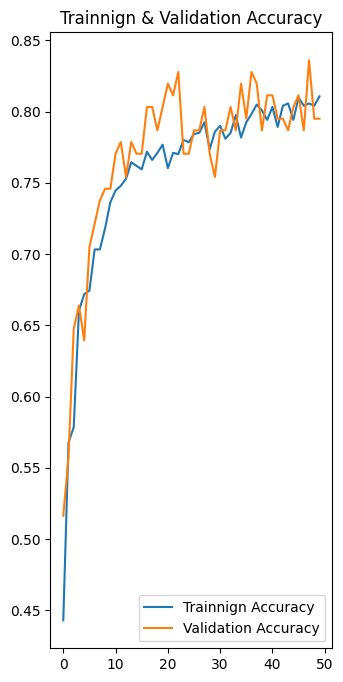

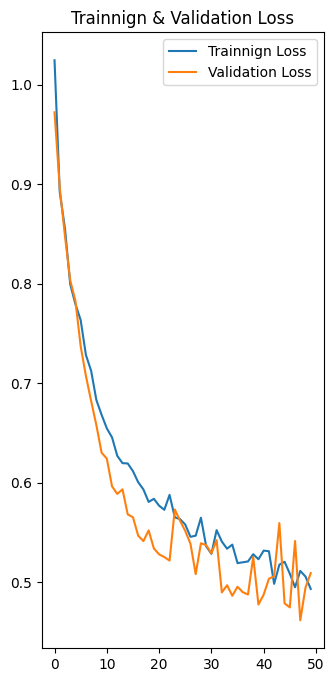

In [35]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [36]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.8126 - loss: 0.4873


[0.5045568943023682, 0.8125]

First image to predict
First image actual label:  Crack
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Label:  Crack


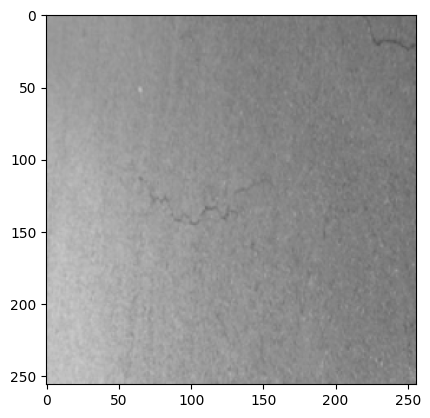

In [37]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_calss = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_calss, confidence 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
92.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
88.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
89.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
70.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
60.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
83.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
96.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
83.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
99.67


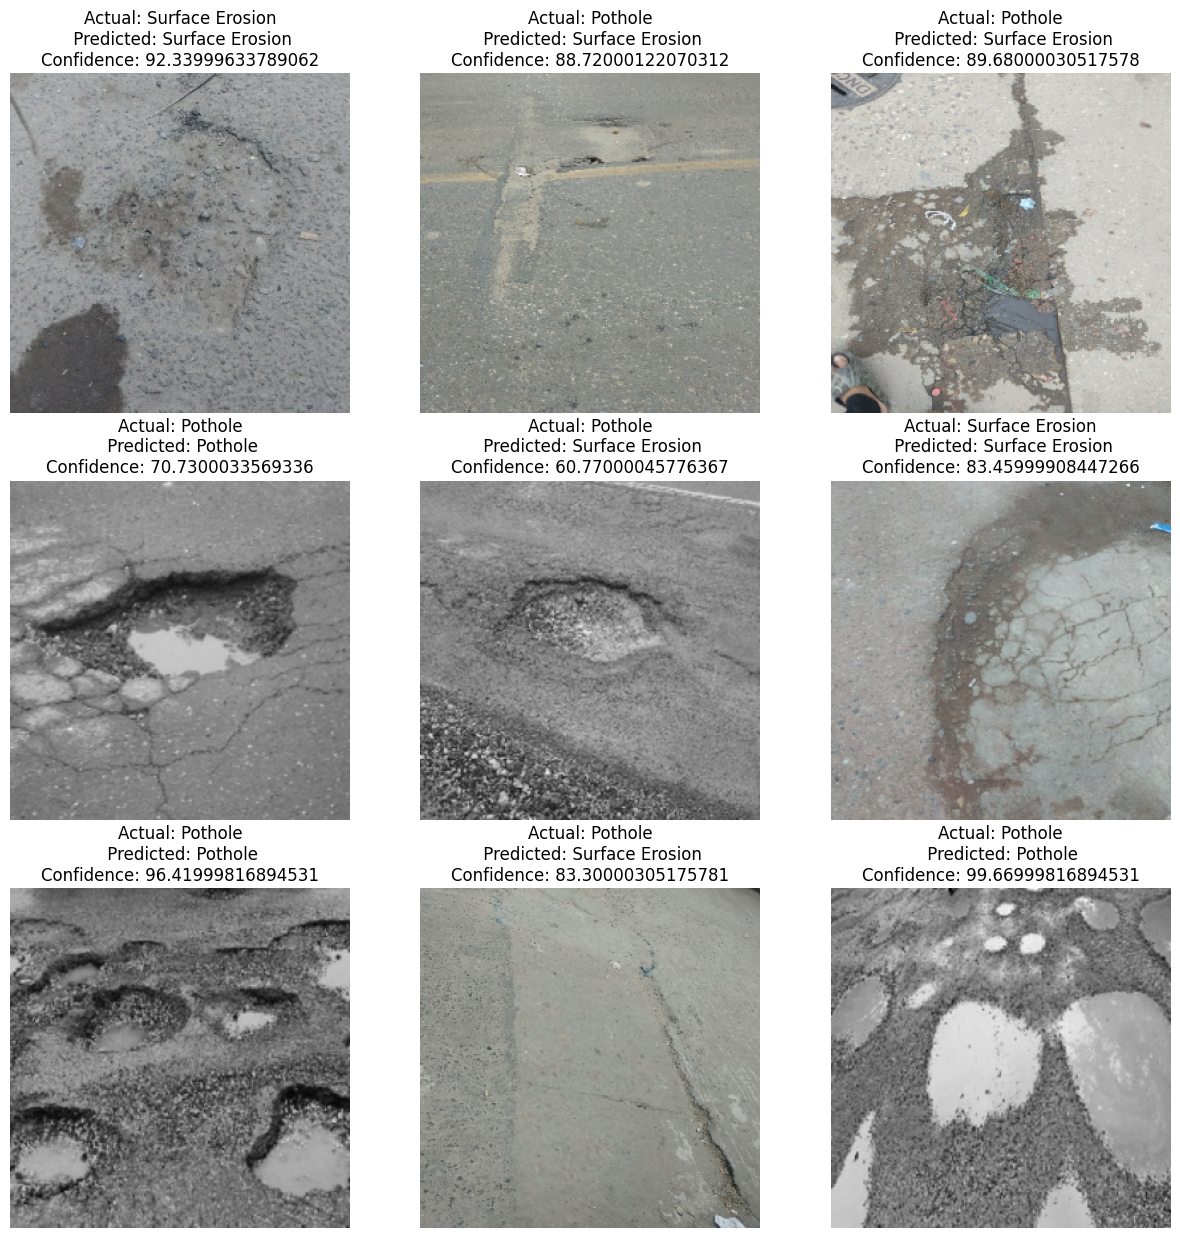

In [39]:

plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, connfidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\nConfidence: {connfidence}")
        print(connfidence)
        plt.axis("off")

In [40]:
confidence_threshold = 0.8
if connfidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {connfidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Pothole, Confidence: 99.66999816894531


In [41]:
# import numpy as np
# import torch
# from typing import List, Dict

# def non_max_suppression(boxes: List[Dict], iou_threshold: float = 0.45) -> List[Dict]:
#     """
#     Apply Non-Maximum Suppression to remove overlapping bounding boxes.
    
#     Args:
#         boxes (List[Dict]): List of dictionaries containing detection info
#                            Each dict should have 'bbox' [x1,y1,x2,y2], 'confidence', and 'class'
#         iou_threshold (float): IoU threshold for considering boxes as overlapping
    
#     Returns:
#         List[Dict]: Filtered list of detections after NMS
#     """
#     # If no boxes, return empty list
#     if not boxes:
#         return []
    
#     # Convert boxes to numpy arrays for processing
#     boxes_array = np.array([[box['bbox'][0], box['bbox'][1], box['bbox'][2], box['bbox'][3]] 
#                            for box in boxes])
#     scores = np.array([box['confidence'] for box in boxes])
    
#     # Get coordinates of bounding boxes
#     x1 = boxes_array[:, 0]
#     y1 = boxes_array[:, 1]
#     x2 = boxes_array[:, 2]
#     y2 = boxes_array[:, 3]
    
#     # Calculate area of bounding boxes
#     areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
#     # Sort by confidence score
#     order = scores.argsort()[::-1]
    
#     keep = []
#     while order.size > 0:
#         # Pick the box with highest confidence
#         i = order[0]
#         keep.append(i)
        
#         # Calculate IoU with rest of the boxes
#         xx1 = np.maximum(x1[i], x1[order[1:]])
#         yy1 = np.maximum(y1[i], y1[order[1:]])
#         xx2 = np.minimum(x2[i], x2[order[1:]])
#         yy2 = np.minimum(y2[i], y2[order[1:]])
        
#         w = np.maximum(0.0, xx2 - xx1 + 1)
#         h = np.maximum(0.0, yy2 - yy1 + 1)
#         inter = w * h
        
#         # Calculate IoU
#         ovr = inter / (areas[i] + areas[order[1:]] - inter)
        
#         # Get indices of boxes with IoU less than threshold
#         inds = np.where(ovr <= iou_threshold)[0]
        
#         # Update order
#         order = order[inds + 1]
    
#     # Return filtered detections
#     return [boxes[i] for i in keep]

# def post_process_detections(detections: List[Dict], confidence_threshold: float = 0.5, 
#                           iou_threshold: float = 0.45) -> List[Dict]:
#     """
#     Post-process detection results using NMS and confidence thresholding
    
#     Args:
#         detections (List[Dict]): List of detection results
#         confidence_threshold (float): Minimum confidence score to keep
#         iou_threshold (float): IoU threshold for NMS
    
#     Returns:
#         List[Dict]: Filtered and processed detections
#     """
#     # Filter by confidence
#     filtered_detections = [det for det in detections if det['confidence'] > confidence_threshold]
    
#     # Apply Non-Maximum Suppression
#     nms_detections = non_max_suppression(filtered_detections, iou_threshold)
    
#     return nms_detections

# # Example usage:
# """
# # Example detection format:
# detections = [
#     {
#         'bbox': [x1, y1, x2, y2],  # coordinates of bounding box
#         'confidence': 0.95,         # confidence score
#         'class': 'car'             # class label
#     },
#     # ... more detections
# ]

# # Process detections
# processed_detections = post_process_detections(detections)
# """

In [42]:
# def post_process_detections(detections, confidence_threshold=0.5, iou_threshold=0.45):
#     """
#     Post-process detection results using NMS and confidence thresholding
#     """
#     # Filter by confidence
#     filtered_detections = [det for det in detections if det['confidence'] > confidence_threshold]
    
#     # Apply Non-Maximum Suppression
#     nms_detections = non_max_suppression(filtered_detections, iou_threshold)
    
#     # Refine bounding boxes if needed
#     refined_detections = refine_boxes(nms_detections)
    
#     return refined_detections

In [43]:
# def optimize_model(model):
#     """
#     Optimize the model for inference
#     """
#     # Convert to ONNX format
#     torch.onnx.export(model, 
#                      dummy_input,
#                      "model.onnx",
#                      opset_version=11)
    
#     # Quantize model (if using PyTorch)
#     quantized_model = torch.quantization.quantize_dynamic(
#         model, {torch.nn.Linear}, dtype=torch.qint8
#     )
    
#     return quantized_model